<a href="https://www.kaggle.com/code/anhonguynth/project-csc14115?scriptVersionId=100570749" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# New York City Taxi Trip Duration

## Problem Statement

### Overview
This is a kaggle competition that challenges us to predict the taxi trip duration in New York city. Dataset is provided by the NYC taxi and Limousine commision for building a model.

Money prize: 30,000$.

Business motivation: providing good driving time estimation to
- Detect bottlenecks that appear in the taxi traffic network.
- Predict the taxi trip price. 

Input: a taxi trip with it's attributes. \
Output: trip duration in seconds. 
 
### Input and Output Data description

There are three files:
- train.csv: (1458644,11)
- test.csv: (625134,9)
- sample_submission.csv: (625134,2) 

| Column name | Description | 
| -------- | -------- | 
| id   | the id for each trip     |
| vendor_id   | the id provided Associated with the trip record     |
| pickup_datetime   | date and time when the meter was engaged     |
| dropoff_datetime   | date and time when the meter was disengaged    |
| passenger_count   | The number of passengers in the taxi    |
| pickup_longitude   | the longitude when the meter was engaged     |
| pickup_latitude   | the latitude when the meter was engaged   |
| dropoff_longitude   | the longitude when the meter was disengaged     |
| dropoff_latitude   | the latitude when the meter was disengaged     |
| store_and_fwd_flag   | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  |
| trip_duration  | duration of the trip in seconds     |


- A record in train.csv

![](https://i.imgur.com/LtLFbTO.png)

- A record in test.csv
![](https://i.imgur.com/gEJR1jT.png)

- A record in sample_submission.csv
![](https://i.imgur.com/zwq0ezw.png)




### Evaluation Metric
- **Root Mean Squared Logarithmic Error** (RMSLE) is the metric was used to assess the result of this contest.

$$\epsilon = \sqrt{\frac{1}{n}\sum^{n}_{i=1}(log(p_i + 1) -log(a_i + 1)) ^2}$$

* With respect to:
    * $\epsilon$: RMSLE score
    * n: the number of records (trip duration's observations) in the dataset
    * $p_i$: the prediction of trip duration
    * $a_i$: the actual value of trip duration
    * log(x): natural logarithm (base is e)

* **The smaller the RMSLE value is, the better the model**.

## Explore data and Extract features

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
!unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
!unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration
# %cd /content/drive/MyDrive/CSC14115 - KHDLUD

In [ ]:
np.random.seed(1987)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train = pd.read_csv('./nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('./nyc-taxi-trip-duration/test.csv')
sample_submission = pd.read_csv('./nyc-taxi-trip-duration/sample_submission.csv')

In [ ]:
train.head(2)

In [ ]:
test.head(2)

### Basic information of datasets (train and test)

* Check whether the dataset has :
    * unique values for the id column.
    * missing values.
    * duplicate record.
    * the trip_duration values are consistent with pickup and dropoff datetime (only for the training dataset).

In [ ]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
    if train.duplicated(keep='first').sum() == 0:
        print("3. No duplicate record")
    if df_type == 'train':
        trip_duration_diff = (pd.to_datetime(train.dropoff_datetime) - pd.to_datetime(train.pickup_datetime)).map(lambda x :x.total_seconds())
        if len(df[np.abs(trip_duration_diff.values - df['trip_duration'].values) > 1]) == 0:
            print("4. Trip_duration is consistent with pickup and dropoff times.")

In [ ]:
check_basic(train, df_type="train")

In [ ]:
check_basic(test, df_type="test")

* Show the datatype of each column in dataset.

In [ ]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

* Show the number of unique values in each column.

In [ ]:
train.nunique()

#### Convert datatypes

* Because datatypes of `pickup_datetime` and `dropoff_datetime` are "**object**" which is difficult when we handle it with built-in functions of pandas $\rightarrow$ we convert it into "**datetime**" datatype to be easy to extract data from these columns.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])

* We convert the datatype of the vendor_id column from **int64** to **object** (str) because:
    * vendor_id is the id provided Associated with the trip record.
    * this column only has 2 unique values, 1 and 2, but it does not mean 2 is bigger than 1.

In [ ]:
train['vendor_id'] = train['vendor_id'].astype(str)
test['vendor_id'] = test['vendor_id'].astype(str)

* Check datatypes after converting

In [ ]:
print("Train:\n", train.dtypes, "\n")
print("Test:\n", test.dtypes)

#### Statistics information of the train set

In [ ]:
train.describe(datetime_is_numeric = True)

* Get numeric, categorical column names

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

##### Numeric columns

In [ ]:
def value_percentages(col):
    val = col.groupby(by=col).count().sort_values(ascending=False)
    total = val.sum()
    return (((val / total)*100).round(1)).to_dict()

def num_values(col):
    return col.nunique()

In [ ]:
train[num_cols].agg([value_percentages, num_values])

* **Observation**:

$→$ The number of distinct values of `pickup_datetime` and `dropoff_datetime` takes up more than **90%** of the dataset $→$ extract the data of these columns to new columns (month, hour, day,...) to reduce the unique.

$→$ The value of longitude and latitude have **float64** datatypes $→$ it is difficult to compare.

##### Categorical columns

In [ ]:
train[cate_cols].agg([value_percentages, num_values])

In [ ]:
train.groupby('store_and_fwd_flag')['trip_duration'].agg(['mean', 'min', 'max'])

* **Observation**:

$→$ The `store_and_fwd_flag` column has only 2 values, N và Y. We decide to remove this column because:

1. The proportions of "N" and "Y" are 99.4% and 0.6%, respectively $→$ "N" dominant this column's value.
2. This column meaning is the flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server $→$ **does not affect** the `trip_duration`.
3. The average trip duration of these two groups has not much different.

### Extract new features

#### From `pickup_datetime`

In [ ]:
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

test.loc[:, 'pick_month'] = test['pickup_datetime'].dt.month
test.loc[:, 'hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'day_of_month'] = test['pickup_datetime'].dt.day
test.loc[:, 'day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [ ]:
train.head(2)

* **Comment**:

$→$ Because this problem predicts the trip_duration so that the `dropoff_datetime` column is not necessary $→$ we **remove** this column.

In [ ]:
train.drop(['pickup_datetime', 'dropoff_datetime'], axis =1, inplace= True)
test.drop(['pickup_datetime'], axis =1, inplace= True)

In [ ]:
train.dtypes

#### Remove `store_and_fwd_flag`

In [ ]:
train.drop('store_and_fwd_flag', axis = 1, inplace=True)
test.drop('store_and_fwd_flag', axis = 1, inplace=True)

In [ ]:
train.head(1)

#### Distance 

* The solution of Beluga about haversine distance and manhattan distance (in km).

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [ ]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                                     test['pickup_longitude'].values,
                                                     test['dropoff_latitude'].values,
                                                     test['dropoff_longitude'].values)

In [ ]:
train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                              train['pickup_longitude'].values,
                                                              train['dropoff_latitude'].values,
                                                              train['dropoff_longitude'].values)

test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                              test['pickup_longitude'].values,
                                                              test['dropoff_latitude'].values,
                                                              test['dropoff_longitude'].values)

In [ ]:
train[["id","distance_haversine","distance_manhattan"]].head(2)

* Determine the direction of pickup and dropoff positions and divide it into 8 bins (N, NE, E, SE, S, SW, W, NW):
    * Bearing_array function from solution of Beluga.
    * Assign direction for each degree.



In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, 
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, 
                                          train['dropoff_longitude'].values)

test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, 
                                          test['pickup_longitude'].values, 
                                          test['dropoff_latitude'].values, 
                                          test['dropoff_longitude'].values)

In [ ]:
train[["id","direction"]].describe()

In [ ]:
new_df = train.copy()
train.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
train.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
train.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
train.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
train.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
train.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
train.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
train.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"


new_df = test.copy()
test.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
test.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
test.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
test.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
test.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
test.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
test.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
test.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"

In [ ]:
train["direction"].unique()

#### Speed features (from Beluga's notebook)

In [ ]:
train.loc[:, "avg_speed_h"] = 1000 * train["distance_haversine"] / train["trip_duration"]
train.loc[:, "avg_speed_m"] = 1000 * train["distance_manhattan"] / train["trip_duration"]

* Based on the tuple of longitude and latitude, we using KMeans in order to cluster pickup and dropoff positions to 100 groups respectively. Learning Kmeans with 500000 examples from both train and test set.
* From the area clustered, the average speed features can be extracted based on pickup, dropoff groups, and pickup hour. These features can be used in test set.

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])

test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

* New features of speed (use average speed of haversine distance) groups by: `hour` - `pickup_cluster`, `hour` - `dropoff_cluster`, `pickup_cluster` - `dropoff_cluster`.
* To avoid learning model being overfitted, we only keep the shared values of each group with a count over 100.
* Average speed of haversine distance is calculated on the train set so that the test set does not leak.

In [ ]:
for gby_cols in [['hour', 'pickup_cluster'],  ['hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

#### Round value of longitude and latitude

* We round the decimal part of longitude and latitude to 3 numbers because the definition of third decimal: **"The third decimal place is worth up to 110 m: it can identify a large agricultural field or institutional campus."**

[Meaning of each decimal number position in latitude and longitude](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude?fbclid=IwAR2IC_iFie8AtwfmZHfHCotaMS3fMaKJ14hNb0yN45Z9g0Z5nTOS9aQcBWE)


In [ ]:
train[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']] = train[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']].round(3)

test[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']] = test[['pickup_longitude', 'pickup_latitude', 
       'dropoff_longitude', 'dropoff_latitude']].round(3)

In [ ]:
num_cols = list(train.select_dtypes(exclude='object').columns)

In [ ]:
train[num_cols].agg([value_percentages, num_values])

* **Observation**:
    * The number of longitudes and latitudes are decrease.
    * The number of unique values in the `distance_haversine` column is nearly the number of rows in dataset.

### Visualize data

#### Histogram all numberic columns

In [ ]:
train[num_cols].hist(figsize=(20, 15), bins = 50)
plt.show()


* Scatter of each numeric column for the number of each value.

In [ ]:
def draw_chart(df, fig_size = (15,15)):
    temp = list(df.columns)
    figure, axis = plt.subplots(len(temp)//2 if len(temp) % 2 == 0 else len(temp)//2 + 1, 2, figsize = fig_size)
    color = ['#582f0e','#936639','#f3722c','#c2c5aa','#414833','#457b9d','#ffb703','#e63946', '#c77dff','#55a630','#f72585','#ffa69e','#4d908e','#7f5539','#b5e48c','#b6ad90','#38b000','#a84c32','#a84c32','#471f13','#8c842d','#408061']
    for i, col in enumerate(temp):
        t = df[col].value_counts()
        axis[i//2, i%2].scatter(list(t.index), t.values, color = color[i])
        axis[i//2, i%2].set_title(col)
    if len(temp) %2 !=0:
        figure.delaxes(axis[len(temp)//2,1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.show()

In [ ]:
draw_chart(train[num_cols], (16,25));

 **Comment**:

- pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude have some values which dominate because in this problem we focus on New York city.
- People in New York tends to go alone (passenger = 1)
- pick_month: in March, the number of people using Taxi is the highest.
- hour: less people uses Taxi at 5am and more at 16-20pm.
- day_of_week: on Monday and Sunday, less people uses Taxi
- day_of_month: at the end of a month, the number of human using Taxi decreases.
- 2 types of distance and average speed have no much different.
- Trip duration is calcuated by second so the range is quite big (1e6) and there are some values that occur most of the time.

#### Trip duration column

In [ ]:
train_log_trip_duration = np.log(train['trip_duration'].values + 1)
plt.hist(train_log_trip_duration, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

#### Average speed depends on hour and day of week

In [ ]:
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(10, 7))
ax[0].plot(train.groupby('hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

**Comment**
- As we can see, because at 5am less people using Taxi so the street won't be crowed $→$ speed will be high. The opposite is true for hours around 16-20pm.
- On Monday and Sunday, the speed is higher than other days.


In [ ]:
# Write features_train.csv
# Write features_test.csv

train.to_csv('features_train.csv', index=False)
test.to_csv('features_test.csv', index=False)

## Modeling
Version 1: Nhóm dựa theo các đặc trưng mà solution đưa ra và đã được nhóm tiền xử lý để huấn luyện mô hình. Các đặc trưng nhóm sử dụng sẽ ở mức độ cơ bản.

In [ ]:
# Read features.csv
train = pd.read_csv('features_train.csv')
test = pd.read_csv('features_test.csv')

In [ ]:
do_not_use_for_training = ['id','trip_duration',"avg_speed_h","avg_speed_m"]
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

In [ ]:
print(len(feature_names)) 
feature_names

In [ ]:
y = np.log(train['trip_duration'].values + 1)

In [ ]:
dtrain = train[feature_names]
dtest = test[feature_names]

### Preprocessor

In [ ]:
# Checking columns that contain null values
dtrain.isnull().sum()

In [ ]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

In [ ]:
!pip install category-encoders

In [ ]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
# import category_encoders as ce
from sklearn.linear_model import LinearRegression

#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)


# scaler = StandardScaler()
# encoder = ce.TargetEncoder(cols=cat_cols)# putting numeric columns to scaler and categorical to encoder
# num_transformer = make_pipeline(imputer, scaler)
# cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])

### Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error

model_linear = LinearRegression()

X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

# giving all values to pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),('linear', model_linear)])
linear_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = linear_pipe.predict(X_val)

In [ ]:
print(linear_pipe)

In [ ]:
# to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred, y_val, squared=False)}")

In [ ]:
y_pre_linear = linear_pipe.predict(test)
y_pre_linear = np.exp(y_pre_linear) - 1
y_pre_linear

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = y_pre_linear
new_df = new_df[['id', 'trip_duration']]
new_df.head()

In [ ]:
new_df.to_csv("submission_linear.csv", index = False)

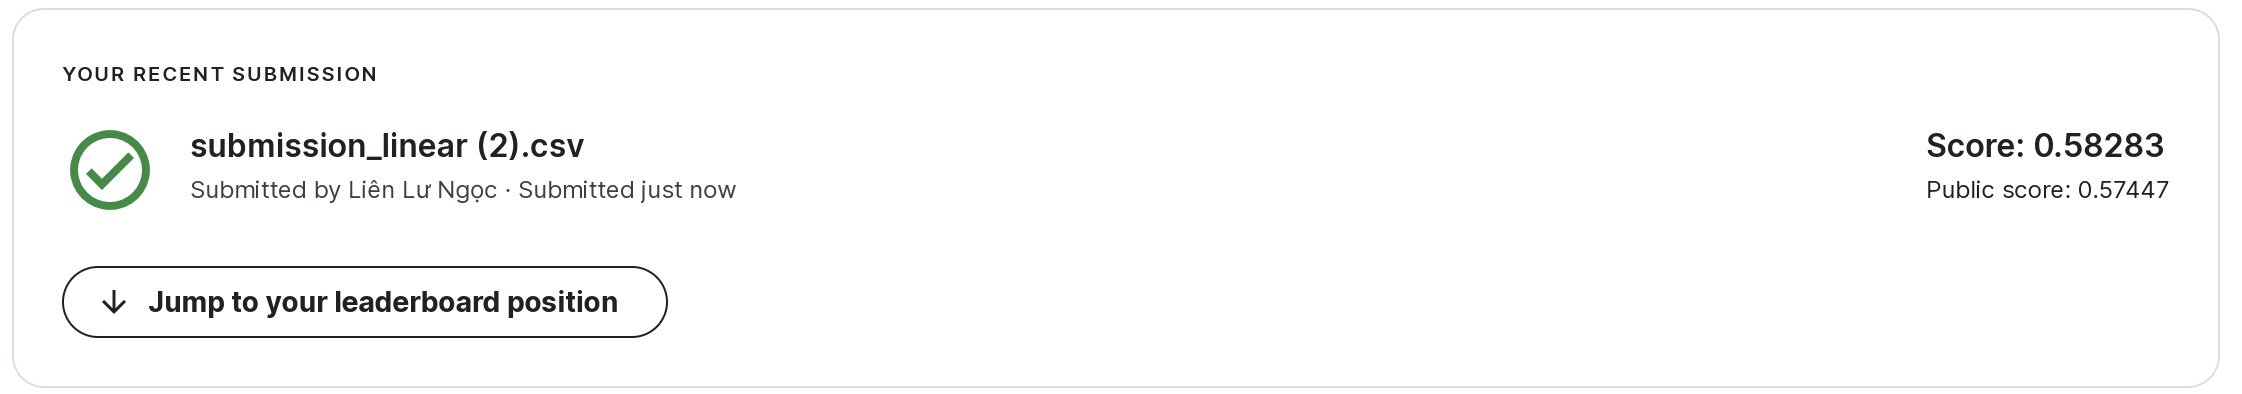

### XGB

https://www.geeksforgeeks.org/xgboost/

In [ ]:
# Data preprocessing pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Transform the data
X_train_xgb = my_pipeline.fit_transform(X_train)
X_val_xgb = my_pipeline.transform(X_val)

In [ ]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train)
dvalid = xgb.DMatrix(X_val_xgb, label=y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Try different parameters! My favorite is random search :)
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
model_xgb = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

In [ ]:
print('Modeling RMSLE %.5f' % model_xgb.best_score)
t1 = dt.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

In [ ]:
dtest = my_pipeline.transform(dtest)
dtest = xgb.DMatrix(dtest)
y_pre_xgb = model_xgb.predict(dtest)
y_pre_xgb

In [ ]:
new_df = test.copy()
new_df['trip_duration'] = np.exp(y_pre_xgb) - 1
new_df = new_df[['id', 'trip_duration']]
new_df.head()

In [ ]:
new_df.to_csv("submission_xgb.csv", index = False)

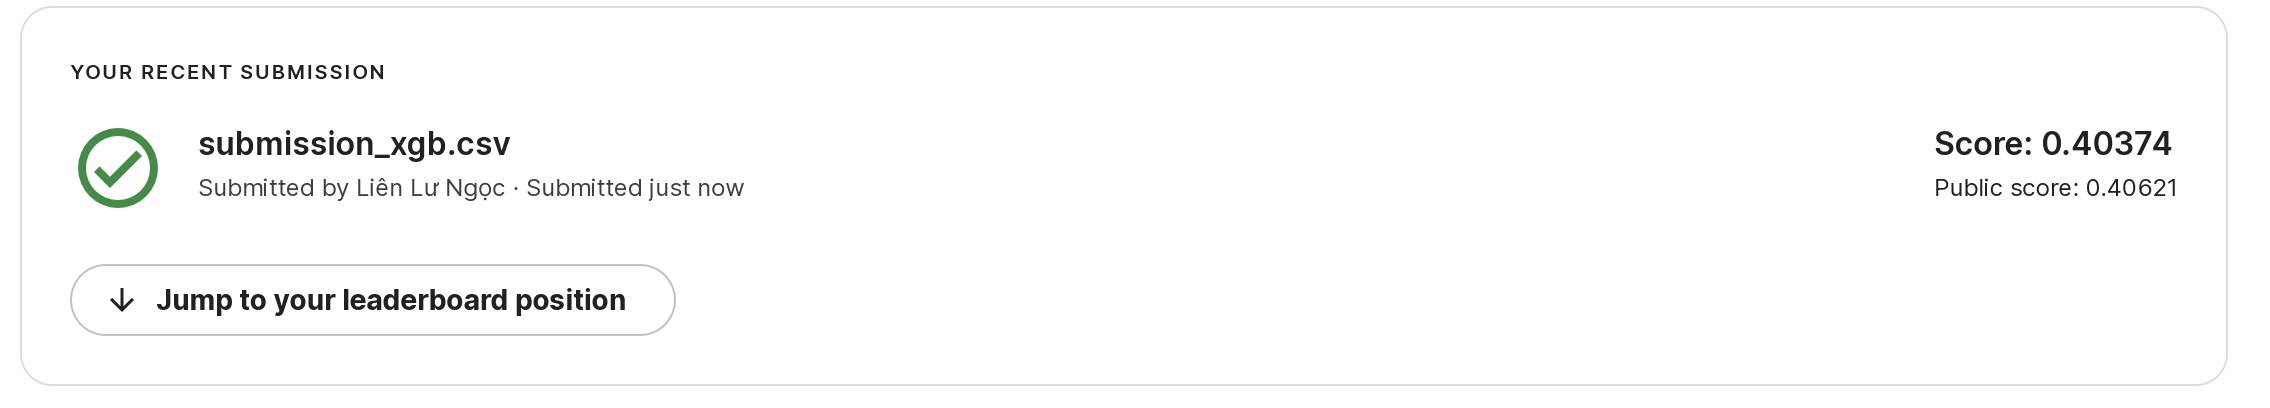

### Stacking model 

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

In [ ]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('xgb', xgb.XGBRegressor()))
	level0.append(('random', RandomForestRegressor()))
	# level0.append(('extra', ExtraTreesRegressor()))
	# level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('linear', LinearRegression()))
	# define meta learner model
	level1 = xgb.XGBRegressor()
	# define the stacking ensemble
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model

In [ ]:
model = get_stacking()    
# giving all values to pipeline
stack_pipe = Pipeline(steps=[('preprocessor', preprocessor),('stack', model)])
stack_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred_stack = stack_pipe.predict(X_val)

In [ ]:
# to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred_stack, y_val, squared=False)}")

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error

## Submission